# NLP Automatic Ticket Assignment Project


# Step 1 : Importing Dependencies

In [3]:
# !pip install chart_studio
# !pip install wordcloud
# !pip install ftfy
!pip install gensim
# Standard Library
import pandas as pd
import numpy as np

from ftfy import *
import nltk

from utils.visualization import *
from utils.datapreprocessing import *

import missingno as msno
import matplotlib.pyplot as plt 
from wordcloud import WordCloud, STOPWORDS
import seaborn as sns 

# For Translation
from googletrans import Translator
from langdetect import detect

    100% |████████████████████████████████| 24.2MB 1.7MB/s ta 0:00:011
    100% |████████████████████████████████| 112kB 6.0MB/s ta 0:00:01
    100% |████████████████████████████████| 133kB 3.6MB/s ta 0:00:01
    100% |████████████████████████████████| 6.3MB 5.0MB/s eta 0:00:01
    100% |████████████████████████████████| 71kB 7.3MB/s ta 0:00:011
  Stored in directory: /Users/jdeshpande/Library/Caches/pip/wheels/27/65/38/8d7f5fe8d7afb4e4566587b2d1933cec185fba19257836c943
Successfully built smart-open


# Step 2. Importing Data and performing basic EDA

In [4]:
filename= "dataset/input_data.xlsx"
df = pd.read_excel(filename, lines=True)

In [5]:
df.head(5)

,Short description,Description,Caller,Assignment group
0,login issue,-verified user details.(employee# & manager na...,spxjnwir pjlcoqds,GRP_0
1,outlook,\r\n\r\nreceived from: hmjdrvpb.komuaywn@gmail...,hmjdrvpb komuaywn,GRP_0
2,cant log in to vpn,\r\n\r\nreceived from: eylqgodm.ybqkwiam@gmail...,eylqgodm ybqkwiam,GRP_0
3,unable to access hr_tool page,unable to access hr_tool page,xbkucsvz gcpydteq,GRP_0
4,skype error,skype error,owlgqjme qhcozdfx,GRP_0


In [6]:
df.count()

Short description    8492
Description          8499
Caller               8500
Assignment group     8500
dtype: int64

In [7]:
# Convert datatype to string
# df = df.applymap(str)
# df.count()

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8500 entries, 0 to 8499
Data columns (total 4 columns):
Short description    8492 non-null object
Description          8499 non-null object
Caller               8500 non-null object
Assignment group     8500 non-null object
dtypes: object(4)
memory usage: 265.7+ KB


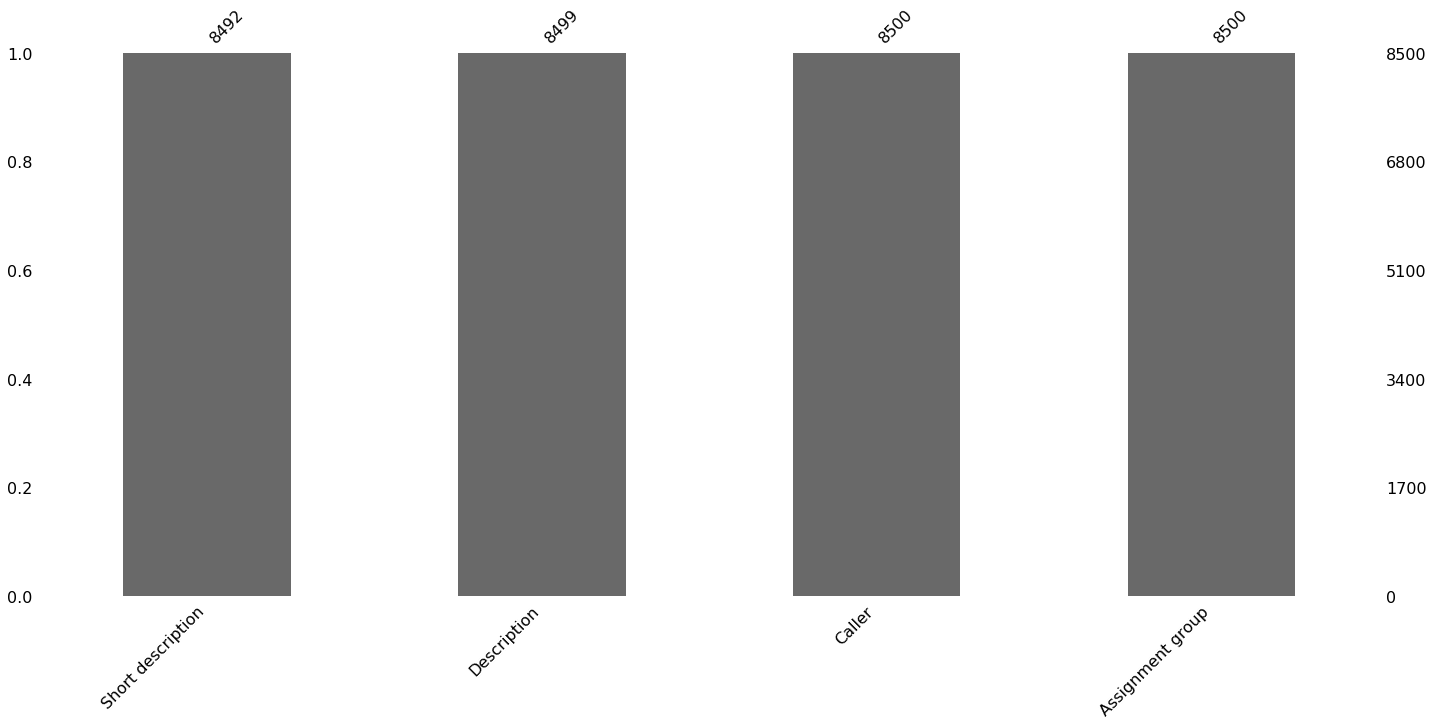

In [9]:
msno.bar(df)

## NOTE : There are 8 NaN Values in 'Short description' Feature, and 1 NaN value in 'Description' Feature.

In [10]:
df['Assignment group'].value_counts()

GRP_0     3976
GRP_8      661
GRP_24     289
GRP_12     257
GRP_9      252
GRP_2      241
GRP_19     215
GRP_3      200
GRP_6      184
GRP_13     145
GRP_10     140
GRP_5      129
GRP_14     118
GRP_25     116
GRP_33     107
GRP_4      100
GRP_29      97
GRP_18      88
GRP_16      85
GRP_17      81
GRP_31      69
GRP_7       68
GRP_34      62
GRP_26      56
GRP_40      45
GRP_28      44
GRP_41      40
GRP_30      39
GRP_15      39
GRP_42      37
          ... 
GRP_36      15
GRP_44      15
GRP_50      14
GRP_53      11
GRP_65      11
GRP_52       9
GRP_51       8
GRP_55       8
GRP_46       6
GRP_49       6
GRP_59       6
GRP_43       5
GRP_32       4
GRP_66       4
GRP_56       3
GRP_63       3
GRP_68       3
GRP_38       3
GRP_58       3
GRP_57       2
GRP_69       2
GRP_54       2
GRP_72       2
GRP_71       2
GRP_67       1
GRP_35       1
GRP_73       1
GRP_70       1
GRP_61       1
GRP_64       1
Name: Assignment group, Length: 74, dtype: int64

## NOTE : There are 74 Dependent/Target classes which are required to be predicted by our Model

# Step 3 : Finding and Treating Missing Values using Rake

## 3(a). Finding NaN Values in 'Short Description' and 'Description'

In [11]:
# For Short Description
df[df['Short description'].isnull()][['Short description', 'Description']]

,Short description,Description
2604,NaN,\r\n\r\nreceived from: ohdrnswl.rezuibdt@gmail...
3383,NaN,\r\n-connected to the user system using teamvi...
3906,NaN,-user unable tologin to vpn.\r\n-connected to...
3910,NaN,-user unable tologin to vpn.\r\n-connected to...
3915,NaN,-user unable tologin to vpn.\r\n-connected to...
3921,NaN,-user unable tologin to vpn.\r\n-connected to...
3924,NaN,name:wvqgbdhm fwchqjor\nlanguage:\nbrowser:mic...
4341,NaN,\r\n\r\nreceived from: eqmuniov.ehxkcbgj@gmail...


In [12]:
# For Description
df[df['Description'].isnull()][['Short description', 'Description']]

,Short description,Description
4395,i am locked out of skype,NaN


## 3(b). Importing and implementing RAKE(Rapid Automatic Keyword Extraction algorithm) for extracting Key phrases
---------------
* Rake extract Key phrases in a body of text by analyzing the frequency of word appearance and its co-occurance with other words in the text. 

* We will group rows of simillar Key phrases and fill missing NaN values from its simillar rows

In [13]:
r = Rake()

In [14]:
# Imputing NaN values in 'Short description' based upon corresponding 'Description' values from other simillar rows in df
df.at[2604, 'Short description'] = 'NaN'
df.at[3383, 'Short description'] = 'NaN'
df.at[3906, 'Short description'] = 'NaN'
df.at[3910, 'Short description'] = 'NaN'
df.at[3915, 'Short description'] = 'NaN'
df.at[3921, 'Short description'] = 'NaN'
df.at[3924, 'Short description'] = 'NaN'
df.at[4341, 'Short description'] = 'NaN'

# Imputing NaN values in 'Description' based upon corresponding 'Description' values from other simillar rows in df
df.at[4395, 'Description'] = 'NaN'

### Implimenting and Extracting Key Phrases in 'Description' and 'Short description'
-----------

In [15]:
df['Raked Short description'] = df['Short description'].apply(rake_implement)
df['Raked Description'] = df['Description'].apply(rake_implement)

### Key Phrases(od Description) for rows with missing Short description values
------

In [16]:
for i in df[df['Short description'] == 'NaN']['Raked Description']:
    print(i, "\n")

['kindly resolve yhe issue', 'urgent basis', 'com hi', 'working', 'rezuibdt', 'received', 'ohdrnswl', 'link', 'gmail', 'best'] 

['user system using teamviewer', 'user login', 'issue resolved', 'portal', 'help', 'connected'] 

['user system using teamviewer', 'vpn company vpn link', 'company vpn using', 'user unable tologin', 'user login', 'issue resolved', 'vpn', 'help', 'connected'] 

['user system using teamviewer', 'vpn company vpn link', 'company vpn using', 'user unable tologin', 'user login', 'issue resolved', 'vpn', 'help', 'connected'] 

['user system using teamviewer', 'vpn company vpn link', 'company vpn using', 'user unable tologin', 'user login', 'issue resolved', 'vpn', 'help', 'connected'] 

['user system using teamviewer', 'vpn company vpn link', 'company vpn using', 'user unable tologin', 'user login', 'issue resolved', 'vpn', 'help', 'connected'] 

['microsoft internet explorer email', 'happen please help aerp', 'com customer number', 'wvqgbdhm fwchqjor language', 'te

### Corresponding 'Description values' for NaN 'Short description' rows

In [17]:
for ind in [2604, 3383, 3906, 3910, 3915, 3921, 3924, 4341]:
    print("---"*3, "Row Id ", ind, "---"*3)
    print(df.iloc[ind, 1], "\n")

--------- Row Id  2604 ---------


received from: ohdrnswl.rezuibdt@gmail.com

hi,



link is not working. kindly resolve yhe issue on urgent basis.



best  

--------- Row Id  3383 ---------

-connected to the user system using teamviewer.
-help the user login to the portal.
-issue resolved. 

--------- Row Id  3906 ---------
-user unable  tologin to vpn.
-connected to the user system using teamviewer.
-help the user login to the company vpn using the vpn company vpn link.
-issue resolved. 

--------- Row Id  3910 ---------
-user unable  tologin to vpn.
-connected to the user system using teamviewer.
-help the user login to the company vpn using the vpn company vpn link.
-issue resolved. 

--------- Row Id  3915 ---------
-user unable  tologin to vpn.
-connected to the user system using teamviewer.
-help the user login to the company vpn using the vpn company vpn link.
-issue resolved. 

--------- Row Id  3921 ---------
-user unable  tologin to vpn.
-connected to the user system usin

### Corresponding 'Short description values' for NaN 'Description' rows

In [18]:
print("---"*3, "Row Id 4395", "---"*3)
print(df.iloc[4395, 0], "\n")

--------- Row Id 4395 ---------
i am locked out of skype 



## 3(b). Replacing NaN Values in 'Short Description' and 'Description' with simillar values from other rows

In [19]:
# Imputing NaN values in 'Short description' based upon corresponding 'Description' values from other simillar rows in df
df.at[2604, 'Short description'] = 'link not working'
df.at[3383, 'Short description'] = 'login issue'
df.at[3906, 'Short description'] = 'vpn login issue'
df.at[3910, 'Short description'] = 'vpn login issue'
df.at[3915, 'Short description'] = 'vpn login issue'
df.at[3921, 'Short description'] = 'vpn login issue'
df.at[3924, 'Short description'] = 'vpn login issue'
df.at[4341, 'Short description'] = 'login failure erp'

# Imputing NaN values in 'Description' based upon corresponding 'Description' values from other simillar rows in df
df.at[4395, 'Description'] = 'i am locked out of skype'

print("Succesfully replaced all NaN values in NaN Values in 'Short Description' and 'Description' feature.")

Succesfully replaced all NaN values in NaN Values in 'Short Description' and 'Description' feature.


In [20]:
df.count().T

Short description          8500
Description                8500
Caller                     8500
Assignment group           8500
Raked Short description    8500
Raked Description          8500
dtype: int64

## NOTE : We can verify that there are no more missing values in any of the features.

# Step 4 : Data Cleaning : Fixing Garbled Text/ Mojibake/Replacing Contractions and Lemmitization
------------------
### The most interesting kind of brokenness that ftfy will fix is when someone has encoded Unicode with one standard and decoded it with a different one. This often shows up as characters that turn into nonsense sequences (called “mojibake”)

## 5(a). Garbled Text/ Mojibake

In [21]:

# Before cleaning Garbled Text/Mojibakes with ftfy
df['Description'][164]

'\n\nreceived from: abcdri@company.com\n\nwindy shi å°†æ’¤å›žé‚®ä»¶"ticket_no1564867 -- comments added"ã€‚\n\n\næœ¬è®¯æ\x81¯ä»…ä¾›æŒ‡å®šçš„æŽ¥æ”¶äººä½¿ç”¨ï¼Œå…¶ä¸\xadå\x8f¯èƒ½åŒ…å\x90«é€‚ç”¨æ³•å¾‹é¡¹ä¸‹ç‰¹è®¸çš„ã€\x81ä¿\x9då¯†çš„å’Œç¦\x81æ\xad¢æŠ«éœ²çš„å†…å®¹ã€‚é™¤æŒ‡å®šçš„æŽ¥æ”¶äººå¤–ï¼Œä¸¥ç¦\x81å…¶ä»–ä»»ä½•äººä¼\xa0æ’\xadã€\x81åˆ†å\x8f‘æˆ–å¤\x8dåˆ¶æœ¬è®¯æ\x81¯ã€‚å¦‚æžœæ‚¨è¯¯æ”¶åˆ°æœ¬è®¯æ\x81¯ï¼Œè¯·é€šçŸ¥å\x8f‘ä»¶äººå¹¶å°†è®¯æ\x81¯åˆ\xa0é™¤ã€‚\n[\nselect the following link to view the disclaimer in an alternate language. '

In [22]:
### Applying ftfy.fix_text 
df['Short description'] = df['Short description'].apply(fix_text)
df['Description'] = df['Description'].apply(fix_text)

## 5(b). Replacing Contractions and Lemmitization

In [23]:
for short_des in df['Short description']:
    short_des = clean_text(short_des)
print("'Short description' cleaning is complete.")

'Short description' cleaning is complete.


In [24]:
for des in df['Description']:
    des = clean_text(des)
print("'Description' Cleaning is complete.")

'Description' Cleaning is complete.


In [25]:
# Clean dataset cloumn Complete_Description

#cleanDataset(df, 'Short description', getRegexList())
#cleanDataset(df, 'Description', getRegexList())
#cleanDataset(df, 'Complete_Description', getRegexList())

# Performing a Regex_clean is causing many data to be dropped. HTML Characters/ Non standard syntax and vocabulary characters or words Later

### Checking Data after ftfy/Contraction replacement and Lemmitization

In [26]:
# After cleaning Garbled Text/Mojibakes with ftfy.fix_text
df['Description'][164]

'\n\nreceived from: abcdri@company.com\n\nwindy shi 将撤回邮件"ticket_no1564867 -- comments added"。\n\n\n本讯息仅供指定的接收人使用,其中可能包含适用法律项下特许的、保密的和禁止披露的内容。除指定的接收人外,严禁其他任何人传播、分发或复制本讯息。如果您误收到本讯息,请通知发件人并将讯息删除。\n[\nselect the following link to view the disclaimer in an alternate language. '

## NOTE : We can see that apart from English there are many non-english data points. The objective of the next step is to treat the non English language objects in df.(yet to be done)

## NOTE : We can see many non english noise in data, but we will do a second stage text filtering after translation is done, because many of the non english data will be dropped after being mistakened as noise. 

# Step 5 : Translation

In [27]:
# Inputting Path
filename= "dataset/translated_input_data.csv"

# Importing CSV as df
vaishakh_df = pd.read_csv(filename)

#Renaming Columns
vaishakh_df.columns = ['Short description', 'Description', 'Caller', 'Assignment group', 'Iso_Description', 'Language_Description', 'Translated_Description', 'Iso_Short description', 'Language_Short description', 'Translated_Short description']

In [28]:
vaishakh_df.head()

,Short description,Description,Caller,Assignment group,Iso_Description,Language_Description,Translated_Description,Iso_Short description,Language_Short description,Translated_Short description
0,login issue,-verified user details.(employee# & manager na...,spxjnwir pjlcoqds,GRP_0,en,English,-verified user details.(employee# & manager na...,en,English,login issue
1,outlook,received from: hmjdrvpb.komuaywn@gmail.com ...,hmjdrvpb komuaywn,GRP_0,en,English,received from: hmjdrvpb.komuaywn@gmail.com ...,en,English,outlook
2,cant log in to vpn,received from: eylqgodm.ybqkwiam@gmail.com ...,eylqgodm ybqkwiam,GRP_0,en,English,received from: eylqgodm.ybqkwiam@gmail.com ...,en,English,cant log in to vpn
3,unable to access hr_tool page,unable to access hr_tool page,xbkucsvz gcpydteq,GRP_0,en,English,unable to access hr_tool page,en,English,unable to access hr_tool page
4,skype error,skype error,owlgqjme qhcozdfx,GRP_0,ja,Japanese,skype error,ja,Japanese,skype error


In [29]:
vaishakh_df.head(5)

,Short description,Description,Caller,Assignment group,Iso_Description,Language_Description,Translated_Description,Iso_Short description,Language_Short description,Translated_Short description
0,login issue,-verified user details.(employee# & manager na...,spxjnwir pjlcoqds,GRP_0,en,English,-verified user details.(employee# & manager na...,en,English,login issue
1,outlook,received from: hmjdrvpb.komuaywn@gmail.com ...,hmjdrvpb komuaywn,GRP_0,en,English,received from: hmjdrvpb.komuaywn@gmail.com ...,en,English,outlook
2,cant log in to vpn,received from: eylqgodm.ybqkwiam@gmail.com ...,eylqgodm ybqkwiam,GRP_0,en,English,received from: eylqgodm.ybqkwiam@gmail.com ...,en,English,cant log in to vpn
3,unable to access hr_tool page,unable to access hr_tool page,xbkucsvz gcpydteq,GRP_0,en,English,unable to access hr_tool page,en,English,unable to access hr_tool page
4,skype error,skype error,owlgqjme qhcozdfx,GRP_0,ja,Japanese,skype error,ja,Japanese,skype error


In [30]:
vaishakh_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8500 entries, 0 to 8499
Data columns (total 10 columns):
Short description               8492 non-null object
Description                     8499 non-null object
Caller                          8500 non-null object
Assignment group                8500 non-null object
Iso_Description                 8500 non-null object
Language_Description            8500 non-null object
Translated_Description          8499 non-null object
Iso_Short description           8500 non-null object
Language_Short description      8500 non-null object
Translated_Short description    8492 non-null object
dtypes: object(10)
memory usage: 664.1+ KB


In [31]:
translated_df = pd.concat([df, vaishakh_df.drop(['Short description', 'Description', 'Caller', 'Assignment group'], axis=1)], axis=1)

In [32]:
translated_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8500 entries, 0 to 8499
Data columns (total 12 columns):
Short description               8500 non-null object
Description                     8500 non-null object
Caller                          8500 non-null object
Assignment group                8500 non-null object
Raked Short description         8500 non-null object
Raked Description               8500 non-null object
Iso_Description                 8500 non-null object
Language_Description            8500 non-null object
Translated_Description          8499 non-null object
Iso_Short description           8500 non-null object
Language_Short description      8500 non-null object
Translated_Short description    8492 non-null object
dtypes: object(12)
memory usage: 797.0+ KB


In [33]:
translated_df.head(5)

,Short description,Description,Caller,Assignment group,Raked Short description,Raked Description,Iso_Description,Language_Description,Translated_Description,Iso_Short description,Language_Short description,Translated_Short description
0,login issue,-verified user details.(employee# & manager na...,spxjnwir pjlcoqds,GRP_0,[login issue],"[verified user details, user name, manager nam...",en,English,-verified user details.(employee# & manager na...,en,English,login issue
1,outlook,\n\nreceived from: hmjdrvpb.komuaywn@gmail.com...,hmjdrvpb komuaywn,GRP_0,[outlook],"[somebody please advise, com hello team, skype...",en,English,received from: hmjdrvpb.komuaywn@gmail.com ...,en,English,outlook
2,cant log in to vpn,\n\nreceived from: eylqgodm.ybqkwiam@gmail.com...,eylqgodm ybqkwiam,GRP_0,"[cant log, vpn]","[vpn best, com hi, cannot log, ybqkwiam, recei...",en,English,received from: eylqgodm.ybqkwiam@gmail.com ...,en,English,cant log in to vpn
3,unable to access hr_tool page,unable to access hr_tool page,xbkucsvz gcpydteq,GRP_0,"[access hr_tool page, unable]","[access hr_tool page, unable]",en,English,unable to access hr_tool page,en,English,unable to access hr_tool page
4,skype error,skype error,owlgqjme qhcozdfx,GRP_0,[skype error],[skype error],ja,Japanese,skype error,ja,Japanese,skype error


## 5(a). Detecting and translating the language in "Short_description" features

In [34]:
#df['Translated Short description'] = df['Short description']

In [35]:
'''
for i in range(0,df.shape[0]):
    try:
        Short_description_language = detect(str(df['Short description'][i]))
        if detect(str(df['Short description'][i])) != 'en':
            df['Translated Short description'][i] = Translator().translate(str(df['Short description'][i]),
                                                                            src= Short_description_language,
                                                                            dest='en').text
        else:
            df['Translated Short description'][i] = str(df['Short description'][i])
    except:
        print("This row throws and error:", i)
        df['Translated Short description'][i] = str(df['Short description'][i])
'''

'\nfor i in range(0,df.shape[0]):\n    try:\n        Short_description_language = detect(str(df[\'Short description\'][i]))\n        if detect(str(df[\'Short description\'][i])) != \'en\':\n            df[\'Translated Short description\'][i] = Translator().translate(str(df[\'Short description\'][i]),\n                                                                            src= Short_description_language,\n                                                                            dest=\'en\').text\n        else:\n            df[\'Translated Short description\'][i] = str(df[\'Short description\'][i])\n    except:\n        print("This row throws and error:", i)\n        df[\'Translated Short description\'][i] = str(df[\'Short description\'][i])\n'

In [36]:

print("German (Before Translation):", translated_df['Short description'][1622])
print('\nEnglish (After Translation): ', translated_df['Translated_Short description'][1622])

German (Before Translation): nachdem ich outlook geöffnet habe und eine e-mail angeklickt habe kommt ein blauer kreis der sich dreht und ich nichts 

English (After Translation):  after I open outlook and have an e-mail clicked is a blue circle rotates and I nothing


In [37]:
print("Chinese (Before Translation):",translated_df['Short description'][164])
print('\nEnglish (After Translation): '+translated_df['Translated_Short description'][164])

Chinese (Before Translation): 撤回: ticket_no1564867 -- comments added

English (After Translation): 撤回: ticket_no1564867 -- comments added


## 5(b). Detecting and translating the language in "Description" features

In [38]:
#df['Translated Description'] = df['Description']

In [39]:
'''
for i in range(0,df.shape[0]):
    Description_lang = detect(str(df['Description'][i]))
    try:
        if Description_lang != 'en' : #de
            df['Translated Description'][i] = Translator().translate(str(df['Description'][i]),src= Description_lang, dest='en').text
            print("Current Time for Row Id ", i, "with Language ",Description_lang," is: ", current_time)
        else:
            df['Translated Description'][i] = str(df['Description'][i])
    except:
        print("This row throws and error:", i)
        df['Translated Description'][i] = str(df['Description'][i])
'''

'\nfor i in range(0,df.shape[0]):\n    Description_lang = detect(str(df[\'Description\'][i]))\n    try:\n        if Description_lang != \'en\' : #de\n            df[\'Translated Description\'][i] = Translator().translate(str(df[\'Description\'][i]),src= Description_lang, dest=\'en\').text\n            print("Current Time for Row Id ", i, "with Language ",Description_lang," is: ", current_time)\n        else:\n            df[\'Translated Description\'][i] = str(df[\'Description\'][i])\n    except:\n        print("This row throws and error:", i)\n        df[\'Translated Description\'][i] = str(df[\'Description\'][i])\n'

In [40]:

print("German (Before Translation):",translated_df['Description'][1622])
print('\nEnglish (After Translation): '+translated_df['Translated_Description'][1622])

German (Before Translation): mehr machen. bitte dringend um hilfe. meine mobile tel. nr. 

English (After Translation): make more. Please urgently for help. my mobile tel. No.


In [41]:
print("Chinese (Before Translation):",translated_df['Description'][164])
print('\nEnglish (After Translation): '+translated_df['Translated_Description'][164])

Chinese (Before Translation): 

received from: abcdri@company.com

windy shi 将撤回邮件"ticket_no1564867 -- comments added"。


本讯息仅供指定的接收人使用,其中可能包含适用法律项下特许的、保密的和禁止披露的内容。除指定的接收人外,严禁其他任何人传播、分发或复制本讯息。如果您误收到本讯息,请通知发件人并将讯息删除。
[
select the following link to view the disclaimer in an alternate language. 

English (After Translation): received from: abcdri@company.com windy shi will recall message "ticket_no1564867 - comments added". This message is for the designated recipient to use, which may contain privileged under applicable law, confidentiality and non-disclosure of content. In addition to the designated recipient, any other person is strictly prohibited dissemination, distribution or copying of this message. If you receive this message by mistake, please notify the sender and delete the message. [Select the following link to view the disclaimer in an alternate language.


## 5(c). Findind and fixing missing values in translated data i.e. translated_df
---------------
-> 8 Values are missing in Tranlated_Short description <br>
-> 1 Value is missing in translated_Description <br>
-> All the values missing are in english language <br>
-> We will simply copy the corresponding original values

In [42]:
# For Translated Short Description we can see the respective row values are in english
translated_df[translated_df['Translated_Short description'].isnull()][['Short description', 'Description','Translated_Description']]

,Short description,Description,Translated_Description
2604,link not working,\n\nreceived from: ohdrnswl.rezuibdt@gmail.com...,received from: ohdrnswl.rezuibdt@gmail.com ...
3383,login issue,\n-connected to the user system using teamview...,-connected to the user system using teamviewe...
3906,vpn login issue,-user unable tologin to vpn.\n-connected to t...,-user unable tologin to vpn. -connected to th...
3910,vpn login issue,-user unable tologin to vpn.\n-connected to t...,-user unable tologin to vpn. -connected to th...
3915,vpn login issue,-user unable tologin to vpn.\n-connected to t...,-user unable tologin to vpn. -connected to th...
3921,vpn login issue,-user unable tologin to vpn.\n-connected to t...,-user unable tologin to vpn. -connected to th...
3924,vpn login issue,name:wvqgbdhm fwchqjor\nlanguage:\nbrowser:mic...,name:wvqgbdhm fwchqjor language: browser:micro...
4341,login failure erp,\n\nreceived from: eqmuniov.ehxkcbgj@gmail.com...,received from: eqmuniov.ehxkcbgj@gmail.com ...


In [43]:
# For 'Translated_Description' we can see the respective row values are in english
translated_df[translated_df['Translated_Description'].isnull()][['Short description', 'Translated_Short description', 'Description']]

,Short description,Translated_Short description,Description
4395,i am locked out of skype,i am locked out of skype,i am locked out of skype


In [44]:
# Copying values from 'Short description' which are already correctly imputated
translated_df["Translated_Short description"] = translated_df["Translated_Short description"].fillna(translated_df["Short description"])
print("Succesfully filled all NaN values in 'Translated_Short description'")

Succesfully filled all NaN values in 'Translated_Short description'


In [45]:
# Copying values from 'Description' which are already correctly imputated
translated_df["Translated_Description"] = translated_df["Translated_Description"].fillna(translated_df["Description"])
print("Succesfully filled all NaN values in 'Translated_Description'")

Succesfully filled all NaN values in 'Translated_Description'


In [46]:
# Finding missing values in translated data
translated_df.isnull().sum()

Short description               0
Description                     0
Caller                          0
Assignment group                0
Raked Short description         0
Raked Description               0
Iso_Description                 0
Language_Description            0
Translated_Description          0
Iso_Short description           0
Language_Short description      0
Translated_Short description    0
dtype: int64

In [47]:
translated_df = translated_df.applymap(str)

# Step 6: Feature Engineering : Text Summarizing for large 'Description'/'Translated_Description' Values  
----------

## 6(a). EDA on length of Translated_Description is more than 150

In [48]:
translated_df.loc[ translated_df['Translated_Description'].apply(lambda x : len(x) > 150) ].shape

(2771, 12)

In [49]:
translated_df['Length of Translated_Description Before Summarization'] = translated_df['Translated_Description'].apply(lambda x: len(str(x).split()))

translated_df['Length of Translated_Short description Before Summarization'] = translated_df['Translated_Short description'].apply(lambda x: len(str(x).split()))

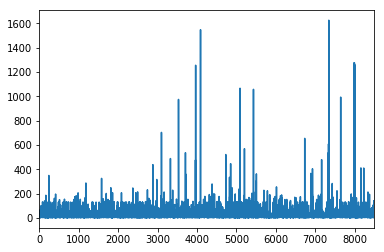

In [50]:
translated_df['Length of Translated_Description Before Summarization'].plot()

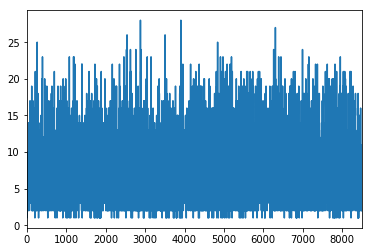

In [51]:
translated_df['Length of Translated_Short description Before Summarization'].plot()

## 6(b). Applying Text Summarization on Translated_Description with more than 150 words

### Testing Out Summarizer feature extractor function

In [52]:
str_me = '''received from: abcdri@company.com windy shi will recall message "ticket_no1564867 - comments added". This message is for the designated recipient to use, which may contain privileged under applicable law, confidentiality and non-disclosure of content. '''

str_me1 ='''  The coronavirus disease is spreading across the country at a rapid pace, but the situation is grim in Maharashtra, Delhi, Tamil Nadu, Haryana, West Bengal, Jammu and Kashmir and Uttar Pradesh.

According to Union health ministry, these states have seen a large number of Covid-19 cases in the last 10 days.

In Delhi, nearly 1,300 cases are being recorded everyday. A fortnight ago, this number was around 1,000. On Thursday, the national capital recorded 1,877 new infections.

In Tamil Nadu, the second worst-affected state after Maharashtra, the single-day spike has nearly doubled from an average 700 to more than 1,300. On Thursday, it registered a record 1,927 Covid-19 cases. There is a three-fold increase in the number of cases in Haryana, and the number has doubled in Jammu and Kashmir, according to health ministry data. There are seven states in the country which have more than 10,000 cases of coronavirus disease.

With the rising number of cases, Uttar Pradesh has now reached the fifth spot on the health ministry’s list of statewise count of Covid-19 cases. The state has registered 201 deaths till May 31. But on Thursday, the Covid-19 fatality count of Uttar Pradesh reached 321.

The nationwide Covid-19 tally neared 2.9 lakh on Thursday with a record one-day increase of nearly 10,000 cases. 
In its morning update, the Union Health Ministry said the total number of confirmed Covid-19 cases has risen to 2,86,579 after a record number of 9,996 cases were reported in 24 hours since Wednesday 8 am.

The death toll also saw a record single-day increase of over 350 fatalities to move closer to the 8,500-mark, more than one-third of which have been recorded in 11 days since June 1 - the day that marked the beginning of a phased exit from most restrictions imposed under a nationwide lockdown with effect from March 25.

The government, however, said the virus infection has not entered the community transmission stage as the lockdown and containment measures prevented a rapid spread.
In its morning update, the Union Health Ministry said the total number of confirmed Covid-19 cases has risen to 2,86,579 after a record number of 9,996 cases were reported in 24 hours since Wednesday 8 am.

The death toll also saw a record single-day increase of over 350 fatalities to move closer to the 8,500-mark, more than one-third of which have been recorded in 11 days since June 1 - the day that marked the beginning of a phased exit from most restrictions imposed under a nationwide lockdown with effect from March 25.

The government, however, said the virus infection has not entered the community transmission stage as the lockdown and containment measures prevented a rapid spread.

In its morning update, the Union Health Ministry said the total number of confirmed Covid-19 cases has risen to 2,86,579 after a record number of 9,996 cases were reported in 24 hours since Wednesday 8 am.

The death toll also saw a record single-day increase of over 350 fatalities to move closer to the 8,500-mark, more than one-third of which have been recorded in 11 days since June 1 - the day that marked the beginning of a phased exit from most restrictions imposed under a nationwide lockdown with effect from March 25.

The government, however, said the virus infection has not entered the community transmission stage as the lockdown and containment measures prevented a rapid spread.

Apart from counting words and characters, our online editor can help you to improve word choice and writing style, and, optionally, help you to detect grammar mistakes and plagiarism. To check word count, simply place your cursor into the text box above and start typing. You'll see the number of characters and words increase or decrease as you type, delete, and edit them. You can also copy and paste text from another program over into the online editor above. The Auto-Save feature will make sure you won't lose any changes while editing, even if you leave the site and come back later. Tip: Bookmark this page now.

Knowing the word count of a text can be important. For example, if an author has to write a minimum or maximum amount of words for an article, essay, report, story, book, paper, you name it. WordCounter will help to make sure its word count reaches a specific requirement or stays within a certain limit.

In addition, WordCounter shows you the top 10 keywords and keyword density of the article you're writing. This allows you to know which keywords you use how often and at what percentages. This can prevent you from over-using certain words or word combinations and check for best distribution of keywords in your writing.

In the Details overview you can see the average speaking and reading time for your text, while Reading Level is an indicator of the education level a person would need in order to understand the words you’re using.

Disclaimer: We strive to make our tools as accurate as possible but we cannot guarantee it will always be so.''' 

In [53]:
str_summr = create_summarized_feature(str_me1)
print(str_summr)

The coronavirus disease is spreading across the country at a rapid pace, but the situation is grim in Maharashtra, Delhi, Tamil Nadu, Haryana, West Bengal, Jammu and Kashmir and Uttar Pradesh.
According to Union health ministry, these states have seen a large number of Covid-19 cases in the last 10 days.
On Thursday, it registered a record 1,927 Covid-19 cases.
There is a three-fold increase in the number of cases in Haryana, and the number has doubled in Jammu and Kashmir, according to health ministry data.
With the rising number of cases, Uttar Pradesh has now reached the fifth spot on the health ministry’s list of statewise count of Covid-19 cases.
But on Thursday, the Covid-19 fatality count of Uttar Pradesh reached 321.
The nationwide Covid-19 tally neared 2.9 lakh on Thursday with a record one-day increase of nearly 10,000 cases.
To check word count, simply place your cursor into the text box above and start typing.
You'll see the number of characters and words increase or decrea

In [54]:
print("Word Count of Data before Summarization was ",len(str_me1.split()))
print("Word Count of Data after Summarization is ", len(str_summr.split()))

Word Count of Data before Summarization was  839
Word Count of Data after Summarization is  204


In [55]:
# If the word count is leass than threshold 
str_summr = create_summarized_feature(str_me)
print(str_summr)

received from: abcdri@company.com windy shi will recall message "ticket_no1564867 - comments added". This message is for the designated recipient to use, which may contain privileged under applicable law, confidentiality and non-disclosure of content. 


In [56]:
print("Word Count of Data before Summarization was ",len(str_me.split()))
print("Word Count of Data after Summarization is ", len(str_summr.split()))

Word Count of Data before Summarization was  33
Word Count of Data after Summarization is  33


## Creating a Summarized feature out of Translated_Description

In [57]:
translated_df['Summarized_Translated_Description'] = translated_df['Translated_Description'].apply(create_summarized_feature)

Can't Summarize this sentence as input has only one sentence. Hence, replacing with (Rake + Summarized Value)
Can't Summarize this sentence as input has only one sentence. Hence, replacing with (Rake + Summarized Value)
Can't Summarize this sentence as input has only one sentence. Hence, replacing with (Rake + Summarized Value)
Can't Summarize this sentence as input has only one sentence. Hence, replacing with (Rake + Summarized Value)
Can't Summarize this sentence as input has only one sentence. Hence, replacing with (Rake + Summarized Value)


In [58]:
translated_df['Length of Translated_Description After Summarization'] = translated_df['Summarized_Translated_Description'].apply(lambda x: len(str(x).split()))

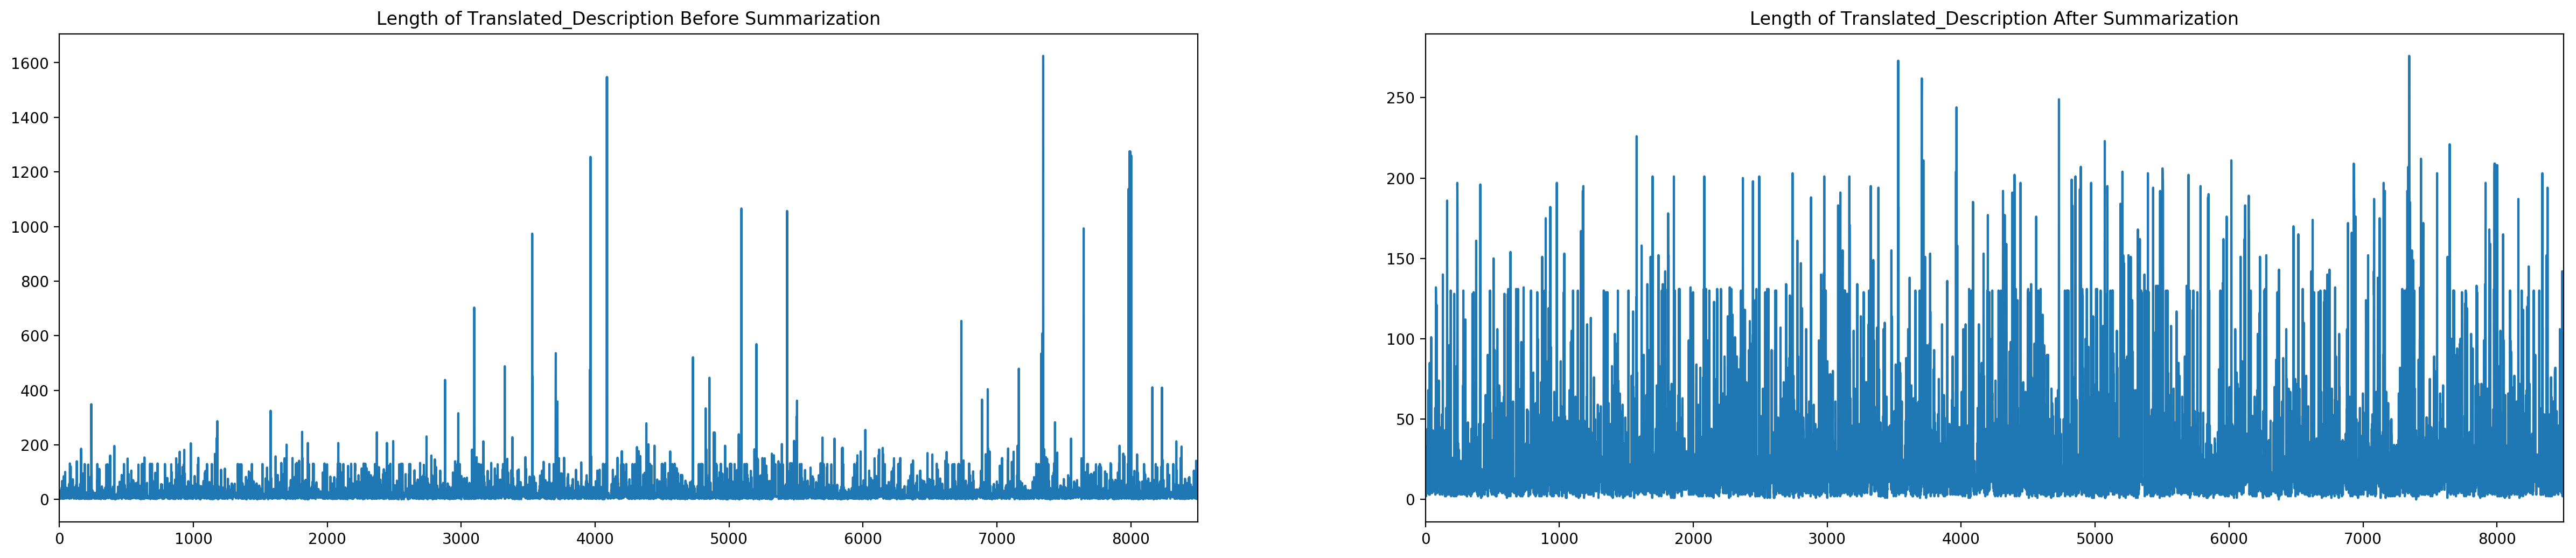

In [59]:
plt.figure(figsize=(30, 6), dpi=200)
plt.subplot(1, 2, 1)
translated_df['Length of Translated_Description Before Summarization'].plot()
plt.title('Length of Translated_Description Before Summarization')

plt.subplot(1, 2, 2)
translated_df['Length of Translated_Description After Summarization'].plot()
plt.title('Length of Translated_Description After Summarization')
plt.show()

In [60]:
translated_df.loc[ translated_df['Summarized_Translated_Description'].apply(lambda x : len(x.split()) > 150) ][['Length of Translated_Description After Summarization', 'Summarized_Translated_Description']]

,Length of Translated_Description After Summarization,Summarized_Translated_Description
162,186,received from: yfqoaepn.xnezhsit@gmail.com ...
238,197,hi all we have a connectivity issue between e...
239,190,please complete all required questions below.\...
379,161,received from: ynsqjehx.kqgrsawl@gmail.com ...
410,196,Myhrt sthry retired as plant manager in usa. i...
635,154,"from: wauhocsk vxuikqaf sent: sunday, october..."
872,151,not able to do pgi for delivery 9169653789- cu...
898,175,production order printer mp7456 is being repla...
932,182,"from: kwddwdw hudfefwe sent: thursday, octobe..."
981,197,*page down to ensure that all required data fi...


# Step 7: Feature Engineering : 'Complete_Description'
----------
Creating a 'Complete_Description' by concatinating 'Translated_Short description' and 'Summarized_Translated_Description' Values  

In [65]:
# Concatenate Short description and Description
translated_df['Complete_Description'] = translated_df['Summarized_Translated_Description'] + " " + translated_df['Translated_Short description']
translated_df.head(10)

,Short description,Description,Caller,Assignment group,Raked Short description,Raked Description,Iso_Description,Language_Description,Translated_Description,Iso_Short description,Language_Short description,Translated_Short description,Length of Translated_Description Before Summarization,Length of Translated_Short description Before Summarization,Summarized_Translated_Description,Length of Translated_Description After Summarization,Complete_Description
0,login issue,-verified user details.(employee# & manager na...,spxjnwir pjlcoqds,GRP_0,['login issue'],"['verified user details', 'user name', 'manage...",en,English,-verified user details.(employee# & manager na...,en,English,login issue,33,2,-verified user details.(employee# & manager na...,33,-verified user details.(employee# & manager na...
1,outlook,\n\nreceived from: hmjdrvpb.komuaywn@gmail.com...,hmjdrvpb komuaywn,GRP_0,['outlook'],"['somebody please advise', 'com hello team', '...",en,English,received from: hmjdrvpb.komuaywn@gmail.com ...,en,English,outlook,25,1,received from: hmjdrvpb.komuaywn@gmail.com ...,25,received from: hmjdrvpb.komuaywn@gmail.com ...
2,cant log in to vpn,\n\nreceived from: eylqgodm.ybqkwiam@gmail.com...,eylqgodm ybqkwiam,GRP_0,"['cant log', 'vpn']","['vpn best', 'com hi', 'cannot log', 'ybqkwiam...",en,English,received from: eylqgodm.ybqkwiam@gmail.com ...,en,English,cant log in to vpn,11,5,received from: eylqgodm.ybqkwiam@gmail.com ...,11,received from: eylqgodm.ybqkwiam@gmail.com ...
3,unable to access hr_tool page,unable to access hr_tool page,xbkucsvz gcpydteq,GRP_0,"['access hr_tool page', 'unable']","['access hr_tool page', 'unable']",en,English,unable to access hr_tool page,en,English,unable to access hr_tool page,5,5,unable to access hr_tool page,5,unable to access hr_tool page unable to access...
4,skype error,skype error,owlgqjme qhcozdfx,GRP_0,['skype error'],['skype error'],ja,Japanese,skype error,ja,Japanese,skype error,2,2,skype error,2,skype error skype error
5,unable to log in to engineering tool and skype,unable to log in to engineering tool and skype,eflahbxn ltdgrvkz,GRP_0,"['engineering tool', 'unable', 'skype', 'log']","['engineering tool', 'unable', 'skype', 'log']",en,English,unable to log in to engineering tool and skype,en,English,unable to log in to engineering tool and skype,9,9,unable to log in to engineering tool and skype,9,unable to log in to engineering tool and skype...
6,event: critical:HostName_221.company.com the v...,event: critical:HostName_221.company.com the v...,jyoqwxhz clhxsoqy,GRP_1,"['mountpoint threshold', 'value', 'sid_37', 'o...","['mountpoint threshold', 'value', 'sr3psa1d_7'...",en,English,event: critical:HostName_221.company.com the v...,en,English,event: critical:HostName_221.company.com the v...,11,9,event: critical:HostName_221.company.com the v...,11,event: critical:HostName_221.company.com the v...
7,ticket_no1550391- employment status - new non-...,ticket_no1550391- employment status - new non-...,eqzibjhw ymebpoih,GRP_0,"['new non', 'enter user', 'employment status',...","['new non', 'enter user', 'employment status',...",en,English,ticket_no1550391- employment status - new non-...,en,English,ticket_no1550391- employment status - new non-...,9,9,ticket_no1550391- employment status - new non-...,9,ticket_no1550391- employment status - new non-...
8,unable to disable add ins on outlook,unable to disable add ins on outlook,mdbegvct dbvichlg,GRP_0,"['disable add ins', 'unable', 'outlook']","['disable add ins', 'unable', 'outlook']",en,English,unable to disable add ins on outlook,en,English,unable to disable add ins on outlook,7,7,unable to disable add ins on outlook,7,unable to disable add ins on outlook unable to...
9,ticket update on inplant_874773,ticket update on inplant_874773,fumkcsji sarmtlhy,GRP_0,"['ticket update', 'inplant_874773']","['ticket update', 'inplant_874773']",en,English,ticket update on inplant_874773,en,English,ticket update on inplant_874773,4,4,ticket update on inplant_

## Finally coverting the df values to str type

In [62]:
# We will use applymap() as it works element-wise on a DataFrame, whereas apply() works on a row / column basis of a DataFrame
translated_df = translated_df.applymap(str)

In [66]:
df = translated_df.copy()

### Label Encoding

Label Encoding refers to converting the labels into numeric form so as to convert it into the machine-readable form. Machine learning algorithms can then decide in a better way on how those labels must be operated. It is an important pre-processing step for the structured dataset in supervised learning.

Label Encoding Assignment group	

### Need of feature extraction techniques
Machine Learning algorithms learn from a pre-defined set of features from the training data to produce output for the test data. But the main problem in working with language processing is that machine learning algorithms cannot work on the raw text directly. So, we need some feature extraction techniques to convert text into a matrix(or vector) of features.
Some of the most popular methods of feature extraction are :

Bag-of-Words

TF-IDF

In [72]:
df['Assignment group'].unique() 

array(['GRP_0', 'GRP_1', 'GRP_3', 'GRP_4', 'GRP_5', 'GRP_6', 'GRP_7',
       'GRP_8', 'GRP_9', 'GRP_10', 'GRP_11', 'GRP_12', 'GRP_13', 'GRP_14',
       'GRP_15', 'GRP_16', 'GRP_17', 'GRP_18', 'GRP_19', 'GRP_2',
       'GRP_20', 'GRP_21', 'GRP_22', 'GRP_23', 'GRP_24', 'GRP_25',
       'GRP_26', 'GRP_27', 'GRP_28', 'GRP_29', 'GRP_30', 'GRP_31',
       'GRP_33', 'GRP_34', 'GRP_35', 'GRP_36', 'GRP_37', 'GRP_38',
       'GRP_39', 'GRP_40', 'GRP_41', 'GRP_42', 'GRP_43', 'GRP_44',
       'GRP_45', 'GRP_46', 'GRP_47', 'GRP_48', 'GRP_49', 'GRP_50',
       'GRP_51', 'GRP_52', 'GRP_53', 'GRP_54', 'GRP_55', 'GRP_56',
       'GRP_57', 'GRP_58', 'GRP_59', 'GRP_60', 'GRP_61', 'GRP_32',
       'GRP_62', 'GRP_63', 'GRP_64', 'GRP_65', 'GRP_66', 'GRP_67',
       'GRP_68', 'GRP_69', 'GRP_70', 'GRP_71', 'GRP_72', 'GRP_73'],
      dtype=object)

In [73]:
# Import label encoder 
from sklearn import preprocessing 
  
# label_encoder object knows how to understand word labels. 
label_encoder = preprocessing.LabelEncoder() 
  
# Encode labels in column 'species'. 
df['Assignment group LabelEncode']= label_encoder.fit_transform(df['Assignment group']) 
  
df['Assignment group LabelEncode'].unique() 

array([ 0,  1, 23, 34, 45, 56, 67, 72, 73,  2,  3,  4,  5,  6,  7,  8,  9,
       10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 24, 25, 27, 28,
       29, 30, 31, 32, 33, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 46, 47,
       48, 49, 50, 51, 52, 53, 54, 55, 57, 58, 26, 59, 60, 61, 62, 63, 64,
       65, 66, 68, 69, 70, 71])

In [75]:
df.head(10)

,Short description,Description,Caller,Assignment group,Raked Short description,Raked Description,Iso_Description,Language_Description,Translated_Description,Iso_Short description,Language_Short description,Translated_Short description,Length of Translated_Description Before Summarization,Length of Translated_Short description Before Summarization,Summarized_Translated_Description,Length of Translated_Description After Summarization,Complete_Description,Assignment group LabelEncode
0,login issue,-verified user details.(employee# & manager na...,spxjnwir pjlcoqds,GRP_0,['login issue'],"['verified user details', 'user name', 'manage...",en,English,-verified user details.(employee# & manager na...,en,English,login issue,33,2,-verified user details.(employee# & manager na...,33,-verified user details.(employee# & manager na...,0
1,outlook,\n\nreceived from: hmjdrvpb.komuaywn@gmail.com...,hmjdrvpb komuaywn,GRP_0,['outlook'],"['somebody please advise', 'com hello team', '...",en,English,received from: hmjdrvpb.komuaywn@gmail.com ...,en,English,outlook,25,1,received from: hmjdrvpb.komuaywn@gmail.com ...,25,received from: hmjdrvpb.komuaywn@gmail.com ...,0
2,cant log in to vpn,\n\nreceived from: eylqgodm.ybqkwiam@gmail.com...,eylqgodm ybqkwiam,GRP_0,"['cant log', 'vpn']","['vpn best', 'com hi', 'cannot log', 'ybqkwiam...",en,English,received from: eylqgodm.ybqkwiam@gmail.com ...,en,English,cant log in to vpn,11,5,received from: eylqgodm.ybqkwiam@gmail.com ...,11,received from: eylqgodm.ybqkwiam@gmail.com ...,0
3,unable to access hr_tool page,unable to access hr_tool page,xbkucsvz gcpydteq,GRP_0,"['access hr_tool page', 'unable']","['access hr_tool page', 'unable']",en,English,unable to access hr_tool page,en,English,unable to access hr_tool page,5,5,unable to access hr_tool page,5,unable to access hr_tool page unable to access...,0
4,skype error,skype error,owlgqjme qhcozdfx,GRP_0,['skype error'],['skype error'],ja,Japanese,skype error,ja,Japanese,skype error,2,2,skype error,2,skype error skype error,0
5,unable to log in to engineering tool and skype,unable to log in to engineering tool and skype,eflahbxn ltdgrvkz,GRP_0,"['engineering tool', 'unable', 'skype', 'log']","['engineering tool', 'unable', 'skype', 'log']",en,English,unable to log in to engineering tool and skype,en,English,unable to log in to engineering tool and skype,9,9,unable to log in to engineering tool and skype,9,unable to log in to engineering tool and skype...,0
6,event: critical:HostName_221.company.com the v...,event: critical:HostName_221.company.com the v...,jyoqwxhz clhxsoqy,GRP_1,"['mountpoint threshold', 'value', 'sid_37', 'o...","['mountpoint threshold', 'value', 'sr3psa1d_7'...",en,English,event: critical:HostName_221.company.com the v...,en,English,event: critical:HostName_221.company.com the v...,11,9,event: critical:HostName_221.company.com the v...,11,event: critical:HostName_221.company.com the v...,1
7,ticket_no1550391- employment status - new non-...,ticket_no1550391- employment status - new non-...,eqzibjhw ymebpoih,GRP_0,"['new non', 'enter user', 'employment status',...","['new non', 'enter user', 'employment status',...",en,English,ticket_no1550391- employment status - new non-...,en,English,ticket_no1550391- employment status - new non-...,9,9,ticket_no1550391- employment status - new non-...,9,ticket_no1550391- employment status - new non-...,0
8,unable to disable add ins on outlook,unable to disable add ins on outlook,mdbegvct dbvichlg,GRP_0,"['disable add ins', 'unable', 'outlook']","['disable add ins', 'unable', 'outlook']",en,English,unable to disable add ins on outlook,en,English,unable to disable add ins on outlook,7,7,unable to disable add ins on outlook,7,unable to disable add ins on outlook unable to...,0
9,ticket update on inplant_874773,ticket update on inplant_874773,fumkcsji sarmtlhy,GRP_0,"['ticket update', 'inplant_874773']","['ticket update', 'inplant_874773']",en,English,ticket update on inplant_874773,en,English,ticket update 

### Term Frequency-Inverse Document Frequency (TF-IDF)

“Term frequency–inverse document frequency, is a numerical statistic that is intended to reflect how important a word is to a document in a collection or corpus.”

In [76]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,f1_score,recall_score,precision_score, confusion_matrix, classification_report


tfidf = TfidfVectorizer()
x_tfidf = tfidf.fit_transform(df['Complete_Description']).toarray()


In [77]:
x_tfidf.shape

(8500, 18921)

In [78]:
x_tfidf[0]

array([0., 0., 0., ..., 0., 0., 0.])

In [79]:
y = df['Assignment group LabelEncode']

In [80]:
y.shape

(8500,)

In [81]:
train_x, test_x, train_y, test_y = train_test_split(x_tfidf, y, test_size=0.3)

### ML Classifier

#### Support Vector Machine

In [82]:
from sklearn.svm import SVC
clf = SVC(kernel='linear').fit(train_x, train_y)
y_pred = clf.predict(test_x)
acc_score = accuracy_score(test_y, y_pred)
print("SVM-Linear Score: ", acc_score)
f_sc = f1_score(test_y, y_pred, average='weighted', labels=np.unique(y_pred))
print("SVM F1 Score: ", f_sc)

SVM-Linear Score:  0.676078431372549
SVM F1 Score:  0.6635637932630333


#### Naive Bayes

In [83]:
from sklearn.naive_bayes import MultinomialNB

clf = MultinomialNB()
clf.fit(train_x, train_y)
y_pred = clf.predict(test_x)
acc_score = accuracy_score(test_y, y_pred)
print("Naive Bayes Score: ", acc_score)
f_sc = f1_score(test_y, y_pred, average='weighted', labels=np.unique(y_pred))
print("Naive Bayes F1 Score: ", f_sc)

Naive Bayes Score:  0.5454901960784314
Naive Bayes F1 Score:  0.6410206318878247


#### Random forest

In [84]:
from sklearn.ensemble import RandomForestClassifier

rfcl = RandomForestClassifier(n_estimators=150, random_state=50, bootstrap=False)
rfcl = rfcl.fit(train_x, train_y)
pred_RF = rfcl.predict(test_x)
acc_RF = accuracy_score(test_y, pred_RF)
print("Random forest Accuracy Score {}".format(acc_RF))

Random forest Accuracy Score 0.6388235294117647


### Deeplearning : ANN

In [85]:
import keras 
import numpy as np
from keras.preprocessing.text import Tokenizer
import numpy as np
import pandas as pd
from keras.models import Sequential
from keras.layers import Dense
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Input, Dense, Dropout, Embedding, LSTM, Flatten
from keras.models import Model
from keras.utils import to_categorical
from keras.callbacks import ModelCheckpoint
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
plt.style.use('ggplot')
%matplotlib inline
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

Using TensorFlow backend.


In [86]:
df.head()

,Short description,Description,Caller,Assignment group,Raked Short description,Raked Description,Iso_Description,Language_Description,Translated_Description,Iso_Short description,Language_Short description,Translated_Short description,Length of Translated_Description Before Summarization,Length of Translated_Short description Before Summarization,Summarized_Translated_Description,Length of Translated_Description After Summarization,Complete_Description,Assignment group LabelEncode
0,login issue,-verified user details.(employee# & manager na...,spxjnwir pjlcoqds,GRP_0,['login issue'],"['verified user details', 'user name', 'manage...",en,English,-verified user details.(employee# & manager na...,en,English,login issue,33,2,-verified user details.(employee# & manager na...,33,-verified user details.(employee# & manager na...,0
1,outlook,\n\nreceived from: hmjdrvpb.komuaywn@gmail.com...,hmjdrvpb komuaywn,GRP_0,['outlook'],"['somebody please advise', 'com hello team', '...",en,English,received from: hmjdrvpb.komuaywn@gmail.com ...,en,English,outlook,25,1,received from: hmjdrvpb.komuaywn@gmail.com ...,25,received from: hmjdrvpb.komuaywn@gmail.com ...,0
2,cant log in to vpn,\n\nreceived from: eylqgodm.ybqkwiam@gmail.com...,eylqgodm ybqkwiam,GRP_0,"['cant log', 'vpn']","['vpn best', 'com hi', 'cannot log', 'ybqkwiam...",en,English,received from: eylqgodm.ybqkwiam@gmail.com ...,en,English,cant log in to vpn,11,5,received from: eylqgodm.ybqkwiam@gmail.com ...,11,received from: eylqgodm.ybqkwiam@gmail.com ...,0
3,unable to access hr_tool page,unable to access hr_tool page,xbkucsvz gcpydteq,GRP_0,"['access hr_tool page', 'unable']","['access hr_tool page', 'unable']",en,English,unable to access hr_tool page,en,English,unable to access hr_tool page,5,5,unable to access hr_tool page,5,unable to access hr_tool page unable to access...,0
4,skype error,skype error,owlgqjme qhcozdfx,GRP_0,['skype error'],['skype error'],ja,Japanese,skype error,ja,Japanese,skype error,2,2,skype error,2,skype error skype error,0


#### Binning the posts by word count.¶
Ideally we would want to know how many posts are short, medium and large posts. Binning is a technique is efficient mechanism to do that

In [92]:
# Adding Word count and Description Length
df['clean_review_len'] = df['Complete_Description'].astype(str).apply(len)
df['clean_word_count'] = df['Complete_Description'].apply(lambda x: len(str(x).split()))

In [93]:
df.head()

,Short description,Description,Caller,Assignment group,Raked Short description,Raked Description,Iso_Description,Language_Description,Translated_Description,Iso_Short description,...,Translated_Short description,Length of Translated_Description Before Summarization,Length of Translated_Short description Before Summarization,Summarized_Translated_Description,Length of Translated_Description After Summarization,Complete_Description,Assignment group LabelEncode,Length_of_Translated_Description_After_Summarization,clean_review_len,clean_word_count
0,login issue,-verified user details.(employee# & manager na...,spxjnwir pjlcoqds,GRP_0,['login issue'],"['verified user details', 'user name', 'manage...",en,English,-verified user details.(employee# & manager na...,en,...,login issue,33,2,-verified user details.(employee# & manager na...,33,-verified user details.(employee# & manager na...,0,33,214,35
1,outlook,\n\nreceived from: hmjdrvpb.komuaywn@gmail.com...,hmjdrvpb komuaywn,GRP_0,['outlook'],"['somebody please advise', 'com hello team', '...",en,English,received from: hmjdrvpb.komuaywn@gmail.com ...,en,...,outlook,25,1,received from: hmjdrvpb.komuaywn@gmail.com ...,25,received from: hmjdrvpb.komuaywn@gmail.com ...,0,25,194,26
2,cant log in to vpn,\n\nreceived from: eylqgodm.ybqkwiam@gmail.com...,eylqgodm ybqkwiam,GRP_0,"['cant log', 'vpn']","['vpn best', 'com hi', 'cannot log', 'ybqkwiam...",en,English,received from: eylqgodm.ybqkwiam@gmail.com ...,en,...,cant log in to vpn,11,5,received from: eylqgodm.ybqkwiam@gmail.com ...,11,received from: eylqgodm.ybqkwiam@gmail.com ...,0,11,98,16
3,unable to access hr_tool page,unable to access hr_tool page,xbkucsvz gcpydteq,GRP_0,"['access hr_tool page', 'unable']","['access hr_tool page', 'unable']",en,English,unable to access hr_tool page,en,...,unable to access hr_tool page,5,5,unable to access hr_tool page,5,unable to access hr_tool page unable to access...,0,5,59,10
4,skype error,skype error,owlgqjme qhcozdfx,GRP_0,['skype error'],['skype error'],ja,Japanese,skype error,ja,...,skype error,2,2,skype error,2,skype error skype error,0,2,23,4


In [94]:
bins=[0,50,75, np.inf]
df['bins']=pd.cut(df.clean_word_count, bins=[0,100,300,500,800, np.inf], labels=['0-100', '100-300', '300-500','500-800' ,'>800'])

In [95]:
word_distribution = df.groupby('bins').size().reset_index().rename(columns={0:'counts'})

In [96]:
word_distribution.head()

,bins,counts
0,0-100,8044
1,100-300,456
2,300-500,0
3,500-800,0
4,>800,0


Text(0.5, 1.0, 'Word distribution per bin')

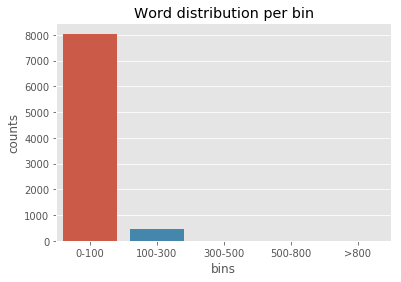

In [97]:
sns.barplot(x='bins', y='counts', data=word_distribution).set_title("Word distribution per bin")

In [98]:
num_class = len(np.unique(df['Assignment group'].values))
y = df['Assignment group LabelEncode'].values

#### Tokenize the input¶
For a deep learning model we need to know what the input sequence length for our model should be. The distribution graph about shows us that for we have more posts with more than 100 words and less than 300 words.

Given the above information we can set the Input sequence length to be max(words per post). By doing so we are essentially wasting a lot of resources so we make a tradeoff and set the the Input sequence length to 500

In [100]:
MAX_LENGTH = 300
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df.Complete_Description.values)
post_seq = tokenizer.texts_to_sequences(df.Complete_Description.values)
post_seq_padded = pad_sequences(post_seq, maxlen=MAX_LENGTH)

In [106]:
X_train, X_test, y_train, y_test = train_test_split(post_seq_padded, y, test_size=0.05)

In [107]:
vocab_size = len(tokenizer.word_index) + 1

In [108]:
inputs = Input(shape=(MAX_LENGTH, ))
embedding_layer = Embedding(vocab_size,
                            128,
                            input_length=MAX_LENGTH)(inputs)
x = Flatten()(embedding_layer)
x = Dense(32, activation='relu')(x)

predictions = Dense(num_class, activation='softmax')(x)
model = Model(inputs=[inputs], outputs=predictions)
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['acc'])

model.summary()
filepath="weights-simple.hdf5"
checkpointer = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
history = model.fit([X_train], batch_size=64, y=to_categorical(y_train), verbose=1, validation_split=0.2, 
          shuffle=True, epochs=10, callbacks=[checkpointer])

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 300)               0         
_________________________________________________________________
embedding_2 (Embedding)      (None, 300, 128)          2388608   
_________________________________________________________________
flatten_2 (Flatten)          (None, 38400)             0         
_________________________________________________________________
dense_3 (Dense)              (None, 32)                1228832   
_________________________________________________________________
dense_4 (Dense)              (None, 74)                2442      
Total params: 3,619,882
Trainable params: 3,619,882
Non-trainable params: 0
_________________________________________________________________


/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 6460 samples, validate on 1615 samples
Epoch 1/10
6460/6460 [==============================] - 5s 735us/step - loss: 2.6212 - acc: 0.4920 - val_loss: 2.2548 - val_acc: 0.5337

Epoch 00001: val_acc improved from -inf to 0.53375, saving model to weights-simple.hdf5
Epoch 2/10
6460/6460 [==============================] - 4s 666us/step - loss: 1.9830 - acc: 0.5539 - val_loss: 1.9817 - val_acc: 0.5647

Epoch 00002: val_acc improved from 0.53375 to 0.56471, saving model to weights-simple.hdf5
Epoch 3/10
6460/6460 [==============================] - 5s 733us/step - loss: 1.6282 - acc: 0.6115 - val_loss: 1.8458 - val_acc: 0.5969

Epoch 00003: val_acc improved from 0.56471 to 0.59690, saving model to weights-simple.hdf5
Epoch 4/10
6460/6460 [==============================] - 4s 674us/step - loss: 1.3006 - acc: 0.6721 - val_loss: 1.7480 - val_acc: 0.6087

Epoch 00004: val_acc improved from 0.59690 to 0.60867, saving model to weights-simple.hdf5
Epoch 5/10
6460/6460 [=====================

In [109]:
predicted = model.predict(X_test)
predicted = np.argmax(predicted, axis=1)
accuracy_score(y_test, predicted)

0.6329411764705882

#### Deeplearning : RNN

A recurrent neural network (RNN) is a class of artificial neural network where connections between units form a directed graph along a sequence. This allows it to exhibit dynamic temporal behavior for a time sequence.

In [111]:
inputs = Input(shape=(MAX_LENGTH, ))
embedding_layer = Embedding(vocab_size,
                            128,
                            input_length=MAX_LENGTH)(inputs)

x = LSTM(64)(embedding_layer)
x = Dense(32, activation='relu')(x)
predictions = Dense(num_class, activation='softmax')(x)
model = Model(inputs=[inputs], outputs=predictions)
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['acc'])

model.summary()
filepath="weights.hdf5"
checkpointer = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
history = model.fit([X_train], batch_size=64, y=to_categorical(y_train), verbose=1, validation_split=0.25, 
          shuffle=True, epochs=10, callbacks=[checkpointer])

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, 300)               0         
_________________________________________________________________
embedding_4 (Embedding)      (None, 300, 128)          2388608   
_________________________________________________________________
lstm_2 (LSTM)                (None, 64)                49408     
_________________________________________________________________
dense_7 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_8 (Dense)              (None, 74)                2442      
Total params: 2,442,538
Trainable params: 2,442,538
Non-trainable params: 0
_________________________________________________________________


/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 6056 samples, validate on 2019 samples
Epoch 1/10
6056/6056 [==============================] - 17s 3ms/step - loss: 3.0019 - acc: 0.4653 - val_loss: 2.2785 - val_acc: 0.5359

Epoch 00001: val_acc improved from -inf to 0.53591, saving model to weights.hdf5
Epoch 2/10
6056/6056 [==============================] - 17s 3ms/step - loss: 2.0488 - acc: 0.5467 - val_loss: 2.0136 - val_acc: 0.5612

Epoch 00002: val_acc improved from 0.53591 to 0.56117, saving model to weights.hdf5
Epoch 3/10
6056/6056 [==============================] - 16s 3ms/step - loss: 1.7310 - acc: 0.5882 - val_loss: 1.8976 - val_acc: 0.5636

Epoch 00003: val_acc improved from 0.56117 to 0.56365, saving model to weights.hdf5
Epoch 4/10
6056/6056 [==============================] - 16s 3ms/step - loss: 1.4849 - acc: 0.6265 - val_loss: 1.9367 - val_acc: 0.5968

Epoch 00004: val_acc improved from 0.56365 to 0.59683, saving model to weights.hdf5
Epoch 5/10
6056/6056 [==============================] - 17s 3ms/step - loss

In [113]:
predicted = model.predict(X_test)
predicted = np.argmax(predicted, axis=1)
accuracy_score(y_test, predicted)

0.571764705882353